In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import keras
from skimage.filters import gabor_kernel
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("tf")
from skimage.color import rgb2gray
from scipy import ndimage as ndi
 
# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10
from keras.models import model_from_json
import cv2

Using TensorFlow backend.


In [9]:
batch_size = 32
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch
num_classes = 10
epochs = 24
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [10]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    return rst

In [11]:
def add_dimension(data):
    data = np.array([data])
    #re arange the dimension
    print(data.shape)
    data = np.einsum('hijk->ijkh', data)
    return data

In [12]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
train_selected_amount = 50000
test_selected_amount = 10000
num_classes = 10

init_y_train = y_train[:train_selected_amount]
init_y_test = y_test[:test_selected_amount]

x_train = add_dimension(grayscale(x_train[:train_selected_amount]))
x_test = add_dimension(grayscale(x_test[:test_selected_amount]))
y_train = np_utils.to_categorical(init_y_train, num_classes)
y_test = np_utils.to_categorical(init_y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

(1, 50000, 32, 32)
(1, 10000, 32, 32)


In [13]:
def custom_gabor(shape, dtype=None):
    pi = np.pi
    orientation_spread = np.array([0, pi/4, pi/2, pi*3/4, pi, pi*5/4, pi*3/2, 2*pi])
    scales = np.linspace(2, 3, 6)
    real_kernels = []
#     size, sigma, theta, lambda, gamma aspect ratio
    for orientation in orientation_spread:
        for scale in scales:
            real_kernel = cv2.getGaborKernel((5, 5), 1, orientation, scale, 1, 0)
            real_kernels.append(real_kernel)
    real_kernels = np.array([real_kernels])
    real_kernels = np.einsum('hijk->jkhi', real_kernels)
    print(real_kernels.shape)

    real_kernels = K.variable(real_kernels)
    random = K.random_normal(shape, dtype=dtype)
    return real_kernels

In [14]:
def base_model(shape):
    model = Sequential()
    model.add(Conv2D(48, (3, 3), padding='same',kernel_initializer=custom_gabor, data_format='channels_last', input_shape=shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    # sgd = SGD(lr = 0.1, decay = 1e-6, momentum=0.9, nesterov=True)
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    # Train model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [15]:
# json_file = open('models/model5x5.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# load weights into new model
model = base_model(x_train.shape[1:])
model.load_weights("models/model5x5.h5")
print("Loaded model from disk")

(5, 5, 1, 48)
Loaded model from disk


### Freeze first layer

In [16]:
model.layers[0].trainable = False

In [ ]:
# loaded_model.summary(line_length=150)
# loaded_model.pop()
# len(loaded_model.layers)

In [18]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/24
50000/50000 [==============================] - 231s 5ms/step - loss: 0.7977 - acc: 0.7312 - val_loss: 0.7806 - val_acc: 0.7331
Epoch 2/24
50000/50000 [==============================] - 215s 4ms/step - loss: 0.7873 - acc: 0.7340 - val_loss: 0.8282 - val_acc: 0.7209
Epoch 3/24
50000/50000 [==============================] - 206s 4ms/step - loss: 0.7797 - acc: 0.7396 - val_loss: 0.7582 - val_acc: 0.7467
Epoch 4/24
50000/50000 [==============================] - 196s 4ms/step - loss: 0.7743 - acc: 0.7377 - val_loss: 0.7735 - val_acc: 0.7351
Epoch 5/24
50000/50000 [==============================] - 194s 4ms/step - loss: 0.7698 - acc: 0.7411 - val_loss: 0.7732 - val_acc: 0.7428
Epoch 6/24
50000/50000 [==============================] - 193s 4ms/step - loss: 0.7683 - acc: 0.7420 - val_loss: 0.7748 - val_acc: 0.7392
Epoch 7/24
50000/50000 [==============================] - 192s 4ms/step - loss: 0.7580 - acc: 0.7449 - val_loss: 0.7540 - 

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7849168494224549
Test accuracy: 0.7345


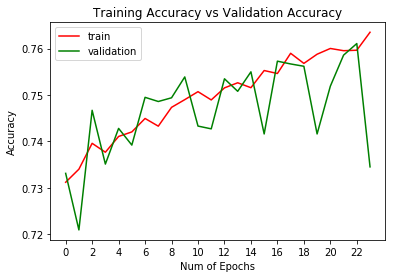

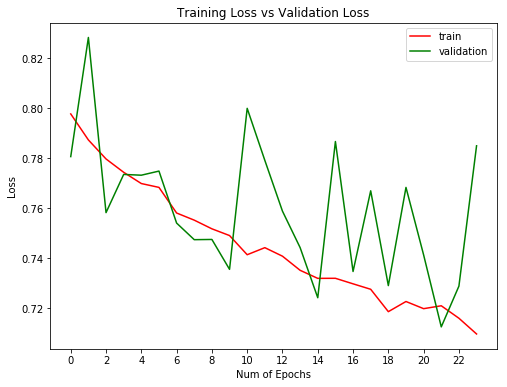

In [26]:
# Plots for training and testing process: loss and accuracy

plt.figure(0)
plt.plot(cnn_history.history['acc'],'r')
plt.plot(cnn_history.history['val_acc'],'g')
plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])


plt.figure(1)
plt.plot(cnn_history.history['loss'],'r')
plt.plot(cnn_history.history['val_loss'],'g')
plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


plt.show()

In [ ]:
# serialize model to JSON
model_json = loaded_model.to_json()
with open("models/transferred_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights("models/transferred_model.h5")
print("Saved model to disk")

In [27]:
cnn_history.history

{'val_loss': [0.7805916722297669,
  0.8282468481063843,
  0.7581774716377259,
  0.7734606293678283,
  0.773150765800476,
  0.7747961918830871,
  0.7539996437072753,
  0.7473594528198242,
  0.7474486000061035,
  0.7354905382156373,
  0.7998938787460327,
  0.7790924331665039,
  0.7587642793655396,
  0.7441903868675231,
  0.724137230682373,
  0.7866226449012756,
  0.7346327498435974,
  0.7669077303886414,
  0.7289879650115967,
  0.7682651124954224,
  0.7412558863639832,
  0.7124767691612244,
  0.7287749814033508,
  0.7849168494224549],
 'val_acc': [0.7331,
  0.7209,
  0.7467,
  0.7351,
  0.7428,
  0.7392,
  0.7495,
  0.7486,
  0.7494,
  0.7539,
  0.7433,
  0.7427,
  0.7535,
  0.7508,
  0.755,
  0.7416,
  0.7573,
  0.7567,
  0.7562,
  0.7416,
  0.7519,
  0.7586,
  0.7611,
  0.7345],
 'loss': [0.7976632598114014,
  0.7872598758983612,
  0.7796503679847717,
  0.7743127666664124,
  0.7698125778579712,
  0.7682734468650818,
  0.7580274101161957,
  0.7551670826339721,
  0.7517038352680206,
  0.

In [32]:
import pickle
import gzip


    

{'acc': [0.32506, 0.48298, 0.5472, 0.58408, 0.61962, 0.63742, 0.6559, 0.66662, 0.67934, 0.69114, 0.7001, 0.7084, 0.71298, 0.71882, 0.72432, 0.729, 0.72846, 0.73308, 0.73652, 0.7362, 0.73874, 0.7409, 0.74078, 0.74666], 'loss': [1.850315092163086, 1.4798237172698974, 1.3103456286239623, 1.1960170129013061, 1.109419662437439, 1.047269861125946, 0.9957340475654602, 0.9622719343185425, 0.9281033836555481, 0.8961584800338745, 0.8746532991027832, 0.8557099863243103, 0.8397310558509826, 0.8234113494491577, 0.8108484908485413, 0.8047668371582031, 0.7972979287338257, 0.7880315686798096, 0.7826424059009552, 0.7769514287757874, 0.7708473350524903, 0.7672298307800293, 0.7650288053512573, 0.7546960398101806], 'val_acc': [0.4748, 0.5393, 0.5877, 0.6287, 0.6475, 0.6545, 0.6831, 0.7028, 0.7091, 0.713, 0.7024, 0.7152, 0.7147, 0.728, 0.7179, 0.7284, 0.7233, 0.7414, 0.7324, 0.7405, 0.7464, 0.7551, 0.7455, 0.7489], 'val_loss': [1.5239904804229736, 1.3355362447738648, 1.182105471420288, 1.087624091720581, 1

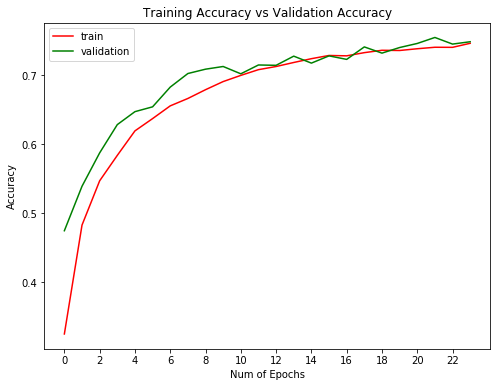

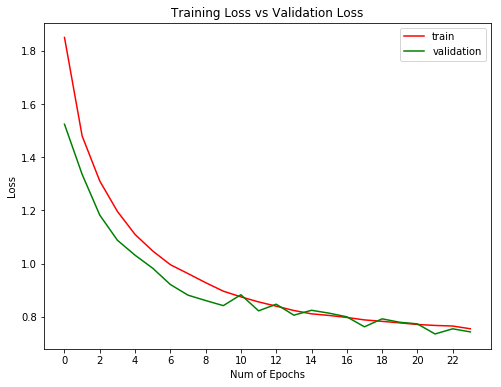

In [33]:
with open('history.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    history = u.load()
    plt.figure(0)
    plt.plot(history['acc'],'r')
    plt.plot(history['val_acc'],'g')
    plt.xticks(np.arange(0, epochs, 2.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['train','validation'])


    plt.figure(1)
    plt.plot(history['loss'],'r')
    plt.plot(history['val_loss'],'g')
    plt.xticks(np.arange(0, epochs, 2.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train','validation'])


    plt.show()